# **Import Library**

In [1]:
%pip install ultralytics -q
%pip install segmentation_models_pytorch -q
%pip install torchmetrics -q
%pip install torch torchvision torchaudio -q
%pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.8 MB/s eta 0:00:00


In [2]:
import os
import yaml
import random
import shutil
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter, defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive

In [3]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchmetrics.classification import JaccardIndex

import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Loading

### Get Data From Gdrive

#### YOLO Segmentation

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dicoding/datasets/food_segmentation.zip

Archive:  /content/drive/MyDrive/dicoding/datasets/food_segmentation.zip
   creating: food_segmentation/
   creating: food_segmentation/images/
  inflating: food_segmentation/images/ayam_goreng_10_jpg.rf.38931a404306c986ee1d0ce77a075a4a.jpg  
  inflating: food_segmentation/images/ayam_goreng_10_jpg.rf.5596b32ab7c2724b34ec32ebeec8609d.jpg  
  inflating: food_segmentation/images/ayam_goreng_11_jpeg.rf.4a8f84b1ce3eb1f058aabf7a9cf76619.jpg  
  inflating: food_segmentation/images/ayam_goreng_11_jpeg.rf.5d1473a0c1d0d101c6aa9ee58d489bee.jpg  
  inflating: food_segmentation/images/ayam_goreng_12_jpg.rf.354241d9330d0118d9b0cc581fb1cbd9.jpg  
  inflating: food_segmentation/images/ayam_goreng_13_jpg.rf.40f5e7e991ed4f463631458e8c7b847a.jpg  
  inflating: food_segmentation/images/ayam_goreng_13_jpg.rf.dc837db85cc16f5687a5f7bbf6237152.jpg  
  inflating: food_segmentation/images/ayam_goreng_14_jpg.rf.81b3edd840cb6d600bfa12b9e619db31.jpg  
  inflating: food_segmentation/images/ayam_goreng_15_jpg.rf.f4

# **Data Splitting**

### YOLO Segmentation

70% Training
20% Validation
10% Test

In [ ]:
# === CONFIG ===
BASE_DIR = "food_segmentation"
OUT_DIR = "dataset_split"
SPLIT_RATIOS = (0.7, 0.2, 0.1)  # train, val, test
random.seed(42)

# === Ensure output dirs ===
splits = ["train", "val", "test"]
subfolders = ["images", "labels"]
for split in splits:
    for sub in subfolders:
        os.makedirs(os.path.join(OUT_DIR, split, sub), exist_ok=True)

# === List all images ===
all_images = sorted(os.listdir(os.path.join(BASE_DIR, "images")))
random.shuffle(all_images)

# === Split indices ===
n_total = len(all_images)
n_train = int(n_total * SPLIT_RATIOS[0])
n_val = int(n_total * SPLIT_RATIOS[1])
n_test = n_total - n_train - n_val

splits_idx = {
    "train": all_images[:n_train],
    "val": all_images[n_train:n_train + n_val],
    "test": all_images[n_train + n_val:]
}

# === Copy files ===
for split, img_list in splits_idx.items():
    print(f"📦 Processing {split} ({len(img_list)} images)...")
    for img_file in img_list:
        base_name = os.path.splitext(img_file)[0]

        img_src = os.path.join(BASE_DIR, "images", f"{base_name}.jpg")
        label_src = os.path.join(BASE_DIR, "labels", f"{base_name}.txt")

        img_dst = os.path.join(OUT_DIR, split, "images", f"{base_name}.jpg")
        label_dst = os.path.join(OUT_DIR, split, "labels", f"{base_name}.txt")

        # copy files if they exist
        if os.path.exists(img_src): shutil.copy(img_src, img_dst)
        if os.path.exists(label_src): shutil.copy(label_src, label_dst)

print("✅ Dataset successfully split and saved in:", OUT_DIR)

📦 Processing train (548 images)...
📦 Processing val (156 images)...
📦 Processing test (80 images)...
✅ Dataset successfully split and saved in: dataset_split


# **Model Training**

### YOLO Image Segmnetation

#### Create data.yaml

In [ ]:
data = {
    "path": "dataset_split",
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": 18,
    "names": [
        "Ayam Goreng - Dada",
        "Ayam Goreng - Paha",
        "Ayam Goreng - Sayap",
        "French Fries",
        "Jagung",
        "Lalapan",
        "Lele Goreng",
        "Mashed Potato",
        "Nasi Putih",
        "Pisang",
        "Pizza",
        "Roti Putih",
        "Sambal",
        "Saus Tomat",
        "Steak Sapi",
        "Tahu Goreng",
        "Telor Ceplok",
        "Tempe"
    ]
}

with open("data.yaml", "w", encoding="utf-8") as f:
    yaml.dump(data, f, allow_unicode=True, sort_keys=False)

print("✅ data.yaml created successfully!")

✅ data.yaml created successfully!


#### Training

In [ ]:
!yolo segment train model=yolo11s-seg.pt data=data.yaml epochs=50 imgsz=640 \
    hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 degrees=10 translate=0.1 scale=0.5 shear=2.0 flipud=0.2 fliplr=0.5 mosaic=1.0 mixup=0.2

Ultralytics 8.3.211 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

#### Save Model

##### Zip Model

In [ ]:
!zip -r yolo_seg_indo_food_v1.zip runs/segment/train

  adding: runs/segment/train/ (stored 0%)
  adding: runs/segment/train/results.png (deflated 8%)
  adding: runs/segment/train/MaskR_curve.png (deflated 6%)
  adding: runs/segment/train/BoxP_curve.png (deflated 7%)
  adding: runs/segment/train/val_batch0_pred.jpg (deflated 8%)
  adding: runs/segment/train/BoxPR_curve.png (deflated 12%)
  adding: runs/segment/train/BoxF1_curve.png (deflated 5%)
  adding: runs/segment/train/train_batch1401.jpg (deflated 6%)
  adding: runs/segment/train/val_batch1_pred.jpg (deflated 14%)
  adding: runs/segment/train/results.csv (deflated 61%)
  adding: runs/segment/train/BoxR_curve.png (deflated 6%)
  adding: runs/segment/train/train_batch0.jpg (deflated 1%)
  adding: runs/segment/train/val_batch2_labels.jpg (deflated 17%)
  adding: runs/segment/train/confusion_matrix_normalized.png (deflated 14%)
  adding: runs/segment/train/weights/ (stored 0%)
  adding: runs/segment/train/weights/last.pt (deflated 8%)
  adding: runs/segment/train/weights/best.pt (deflat

##### Save on Gdrive

In [ ]:
save_dir = "/content/drive/MyDrive/yolo_models"
os.makedirs(save_dir, exist_ok=True)

!cp /content/yolo_seg_indo_food_v1.zip /content/drive/MyDrive/yolo_models

#### Model Evaluation

##### Training & Validation Loss

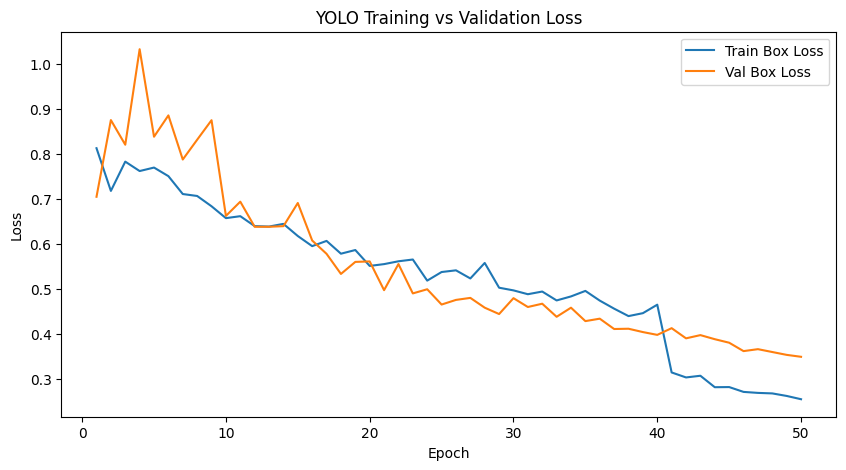

In [ ]:
# Load YOLO training log
df = pd.read_csv("runs/segment/train/results.csv")

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLO Training vs Validation Loss")
plt.legend()
plt.show()

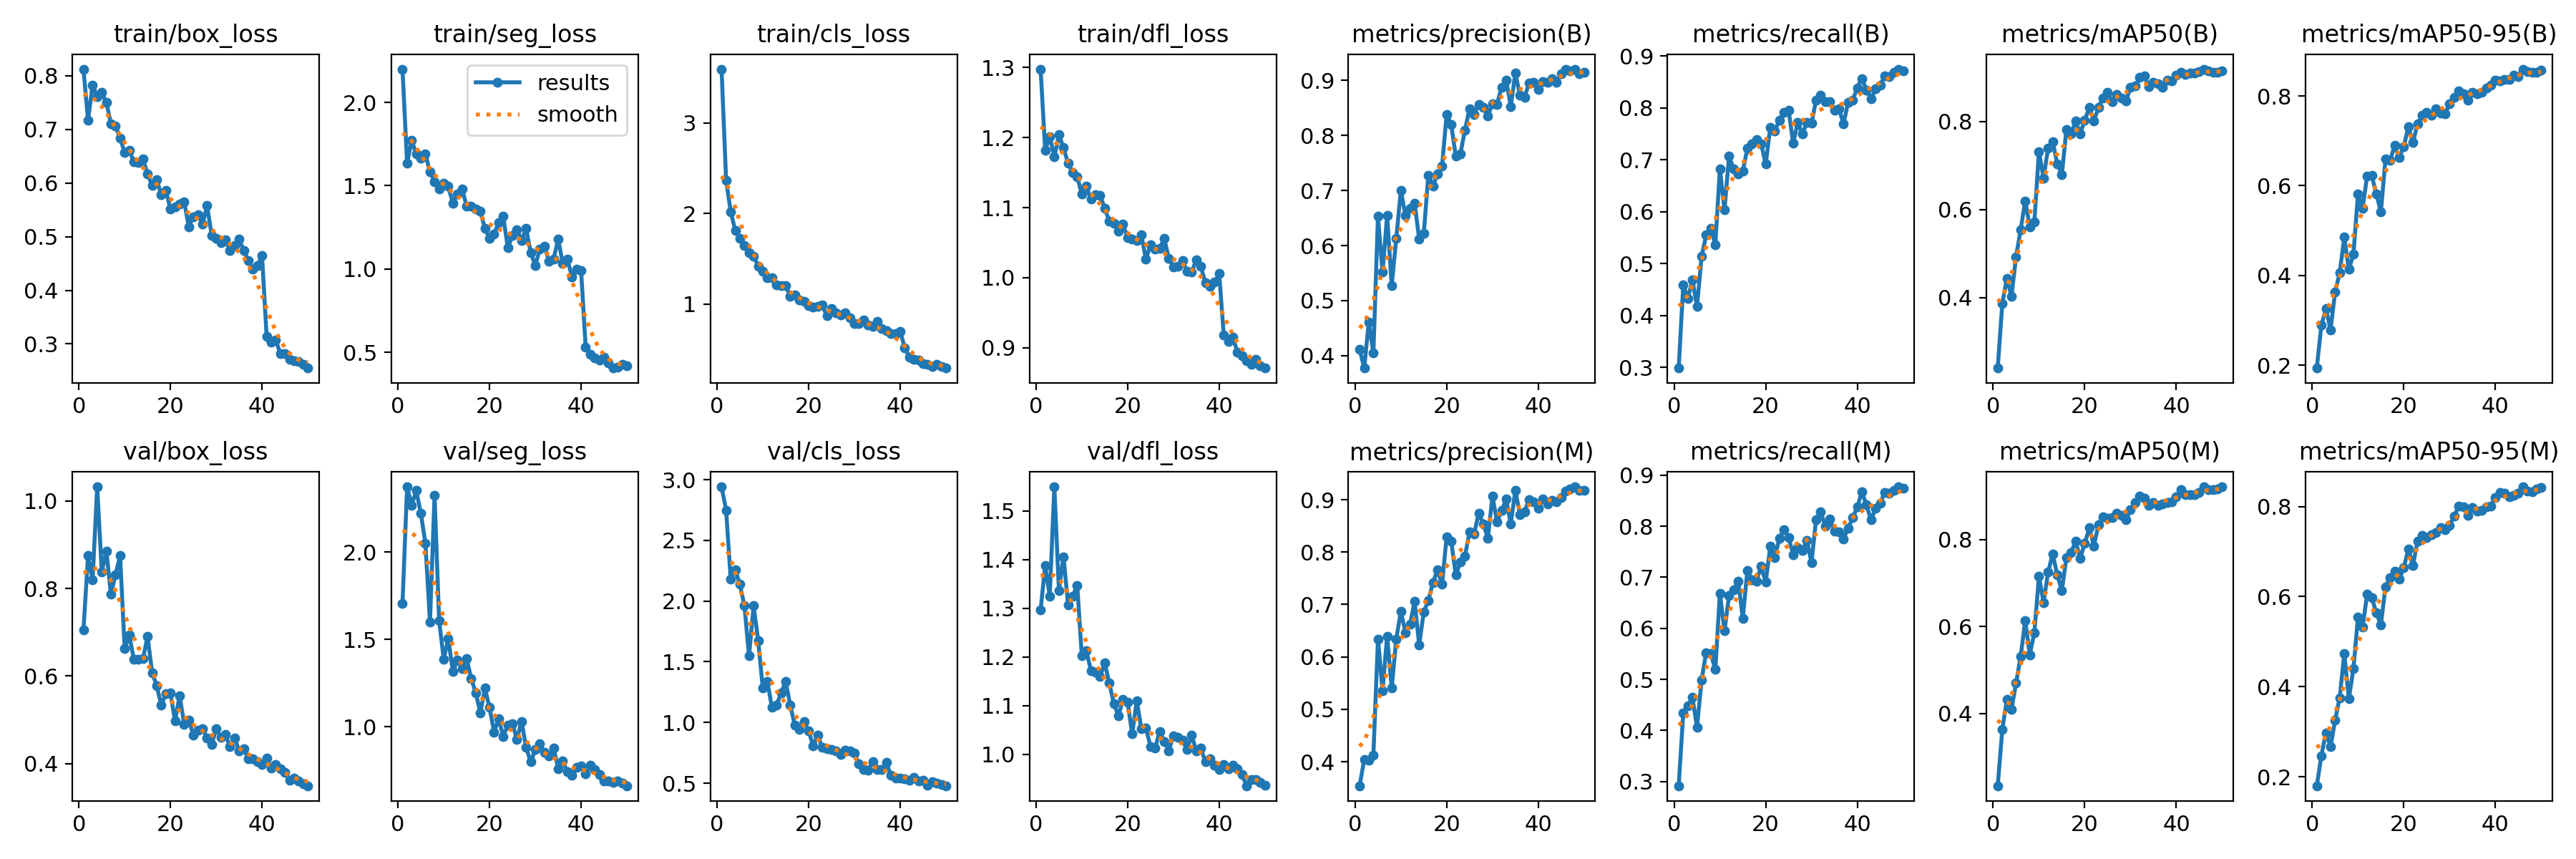

In [ ]:
Image.open("runs/segment/train/results.png")

##### Confussion Matrix

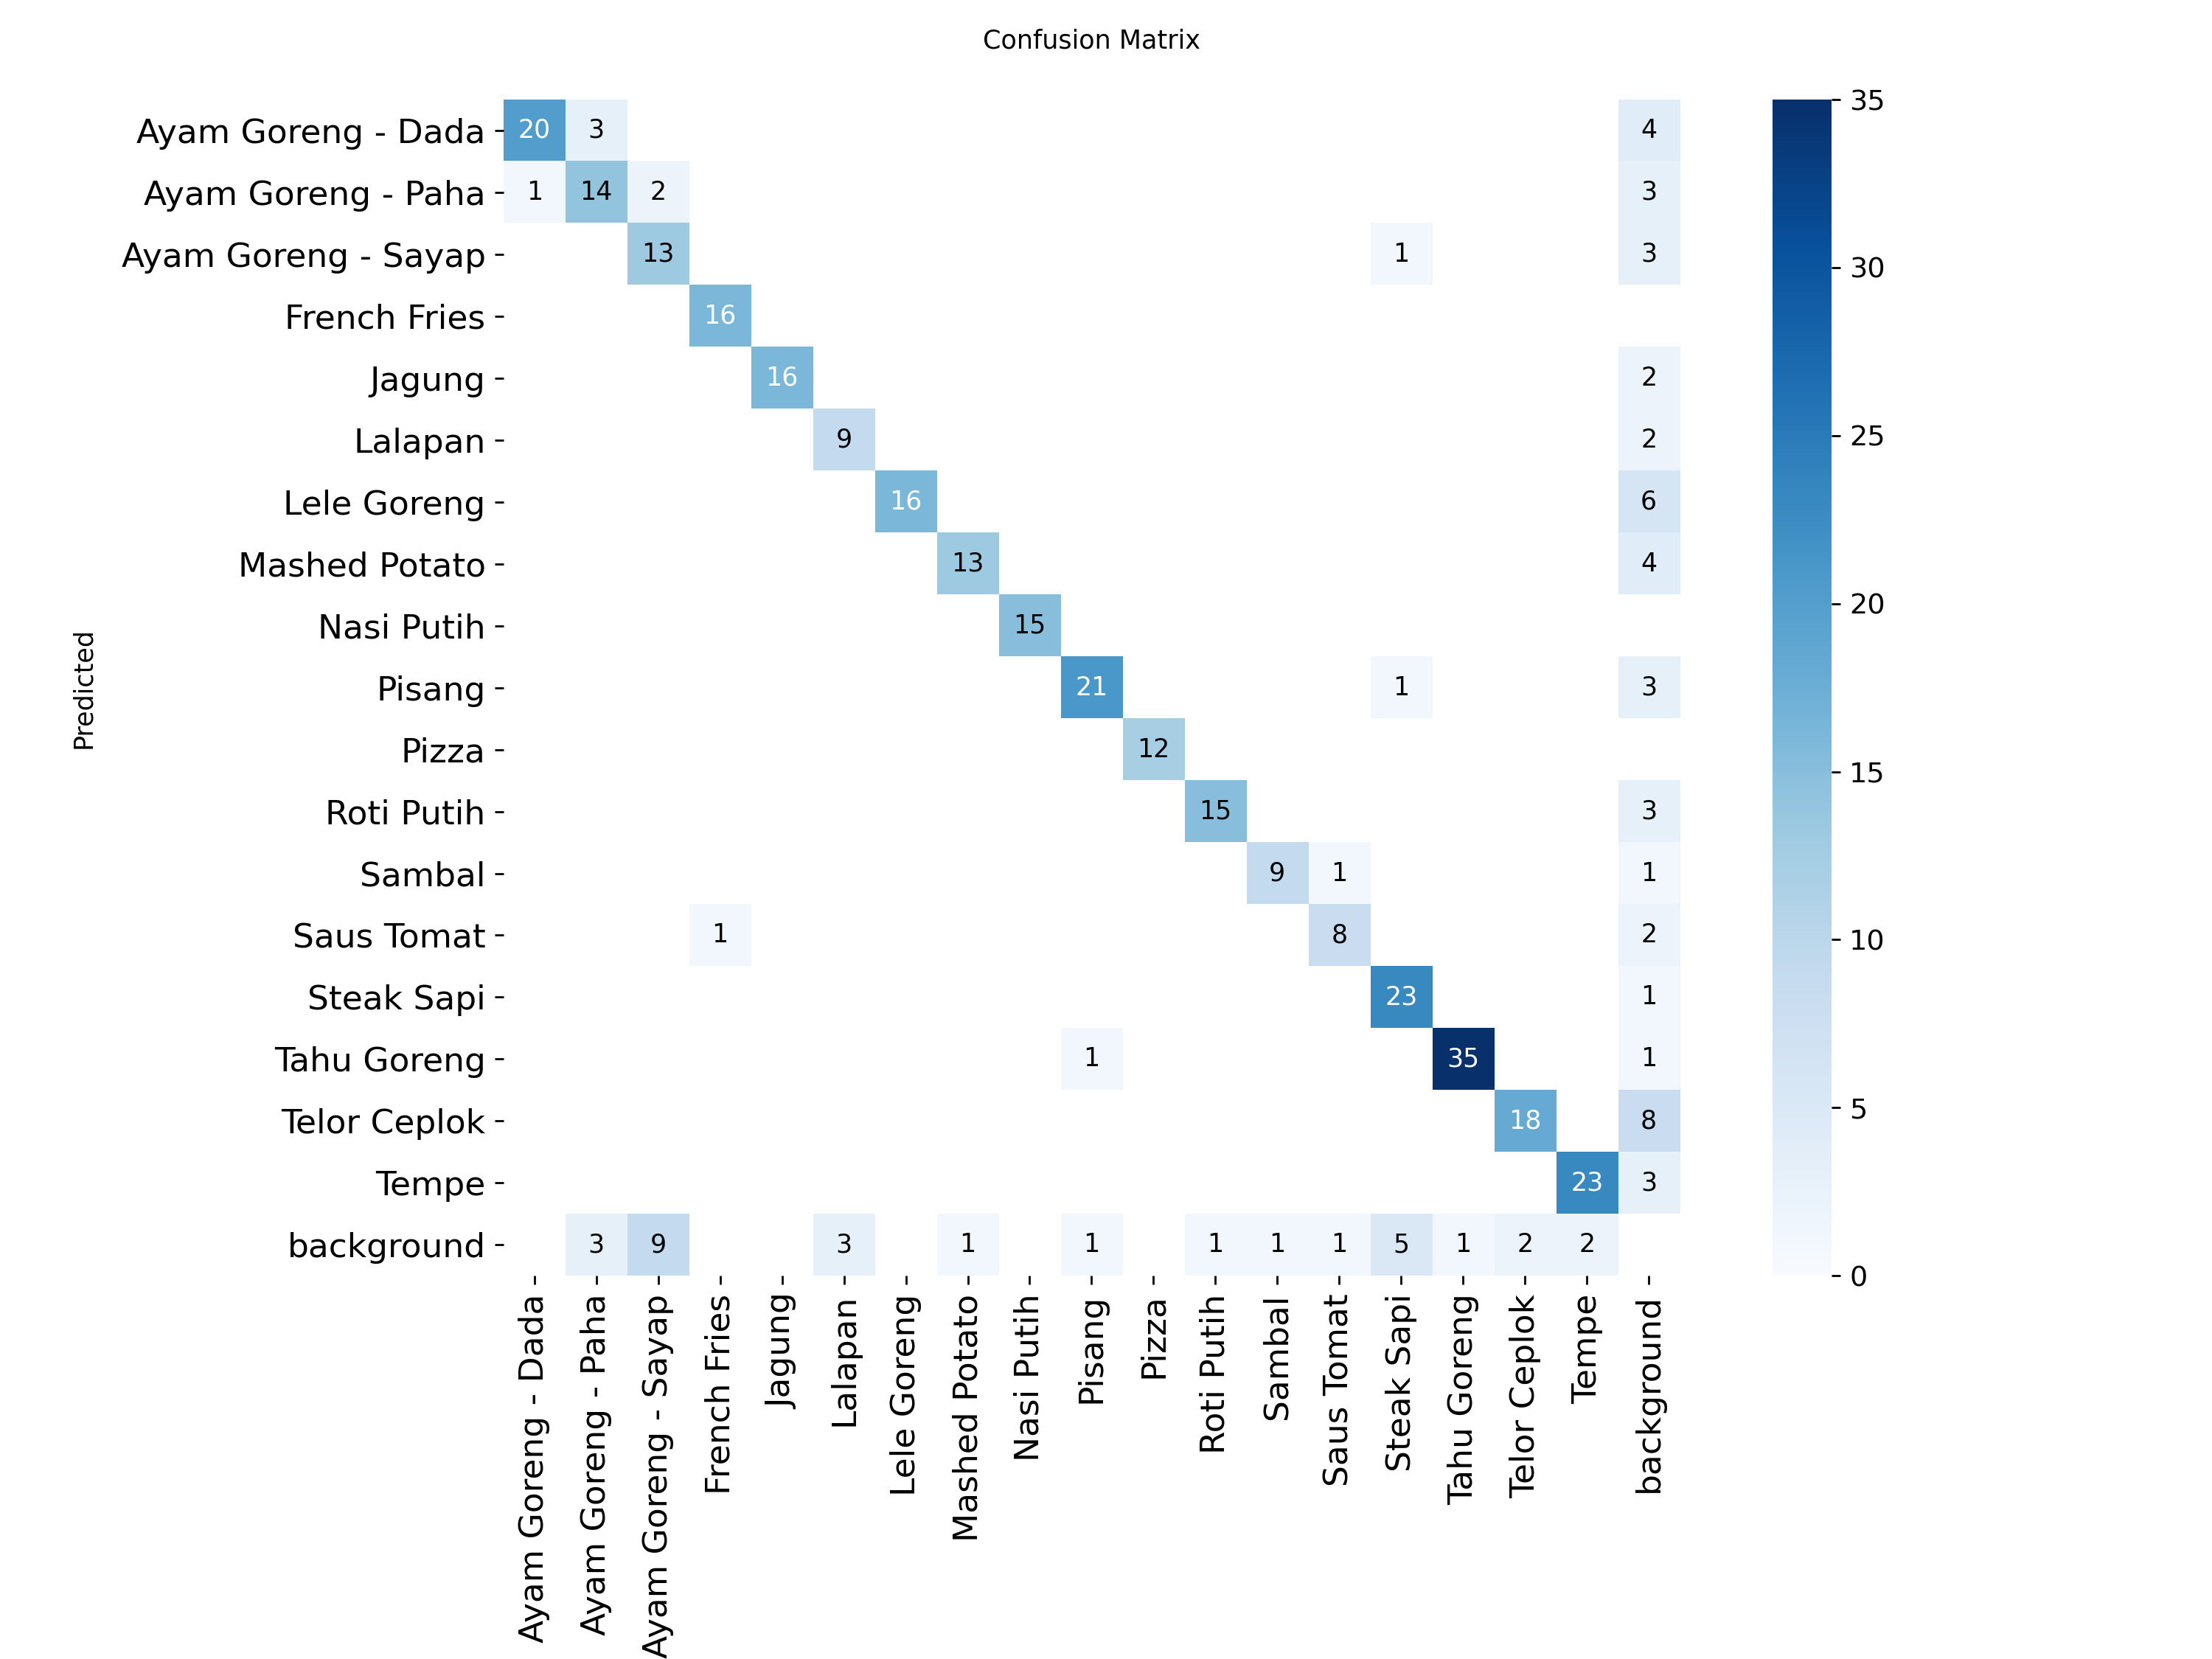

In [ ]:
Image.open("runs/segment/train/confusion_matrix.png")

#### Model Prediction

##### Predict on Test

In [ ]:
!yolo segment predict model=runs/segment/train/weights/best.pt source=dataset_split/test/images save=True

Ultralytics 8.3.211 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s-seg summary (fused): 113 layers, 10,073,782 parameters, 0 gradients, 32.8 GFLOPs

image 1/80 /content/dataset_split/test/images/ayam_goreng_13_jpg.rf.dc837db85cc16f5687a5f7bbf6237152.jpg: 640x640 2 Ayam Goreng - Dadas, 11.3ms
image 2/80 /content/dataset_split/test/images/ayam_goreng_25_jpg.rf.aaa9442c88fec065ab69f09b34342ddd.jpg: 640x640 1 Ayam Goreng - Paha, 3 Ayam Goreng - Sayaps, 11.7ms
image 3/80 /content/dataset_split/test/images/ayam_goreng_27_jpg.rf.4aaacb5b6ae14230f1e0eec2f6cafbd7.jpg: 640x640 1 Ayam Goreng - Paha, 11.0ms
image 4/80 /content/dataset_split/test/images/ayam_goreng_28_jpg.rf.aca994f29dd158acf5f5ebaef29de2fc.jpg: 640x640 1 Ayam Goreng - Dada, 1 French Fries, 10.1ms
image 5/80 /content/dataset_split/test/images/ayam_goreng_29_jpg.rf.ebd32cd425e3a61c62dba40cdc6708b6.jpg: 640x640 2 Ayam Goreng - Dadas, 7 Ayam Goreng - Pahas, 2 Ayam Goreng - Sayaps, 10.0ms
image 6/80 /content/da

##### Display Result

In [ ]:
pred_dir = "runs/segment/predict"

images = sorted([f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))])

# Display first 5 images
for i, img_name in enumerate(images[:5]):
    img_path = os.path.join(pred_dir, img_name)
    img = Image.open(img_path)

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction {i+1}: {img_name}", fontsize=14)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### Evaluation on Test

In [ ]:
!yolo segment val model=runs/segment/train/weights/best.pt data=data.yaml imgsz=640 split=test save=True

Ultralytics 8.3.211 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s-seg summary (fused): 113 layers, 10,073,782 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1986.2±647.6 MB/s, size: 57.7 KB)
val: Scanning /content/dataset_split/test/labels... 80 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 80/80 1.2Kit/s 0.1s
val: New cache created: /content/dataset_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.2it/s 2.3s
                   all         80        205      0.884      0.871      0.927      0.863      0.879      0.866      0.923      0.862
    Ayam Goreng - Dada          8         22      0.739      0.773      0.831      0.818       0.74      0.776      0.831       0.81
    Ayam Goreng - Paha          6         20      0.679       0.75      0.768      0.741      0.676       0.75      

##### Confussion Matrix

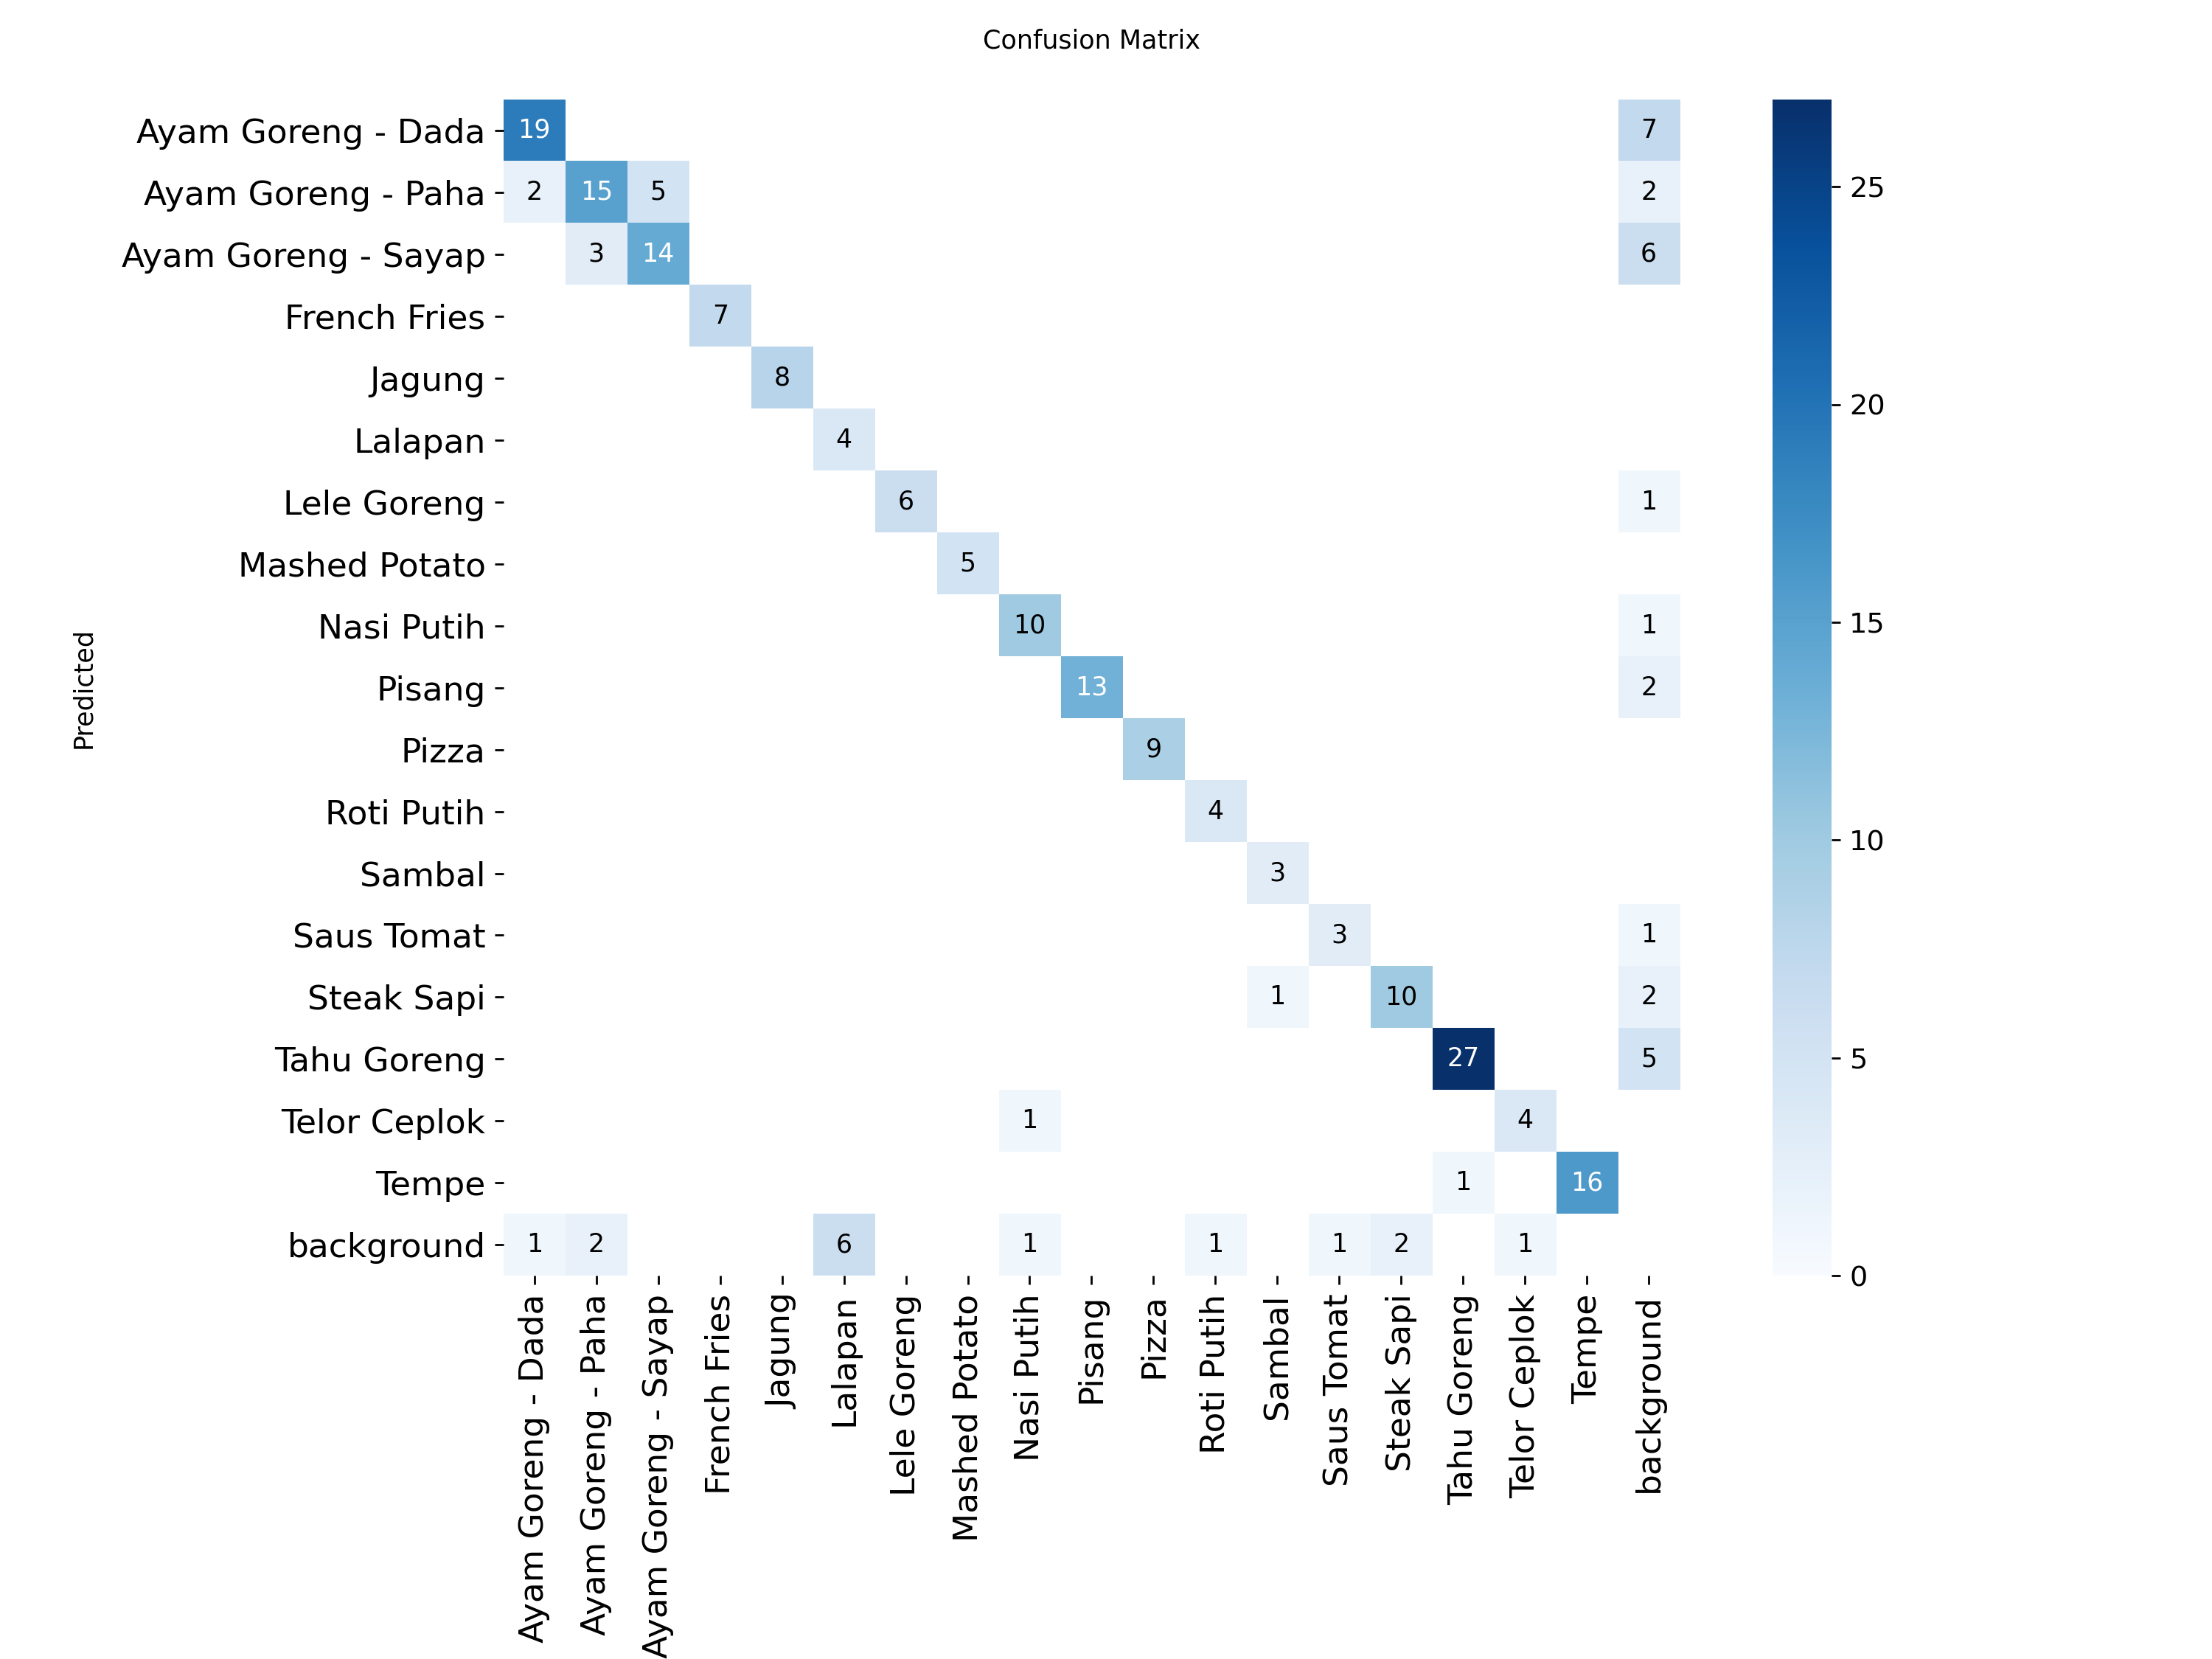

In [ ]:
Image.open("runs/segment/val/confusion_matrix.png")

#### Convert to TF-Lite

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/yolo_models/yolo_seg_indo_food_v1.zip

Archive:  /content/drive/MyDrive/yolo_models/yolo_seg_indo_food_v1.zip
   creating: runs/segment/train/
  inflating: runs/segment/train/results.png  
  inflating: runs/segment/train/MaskR_curve.png  
  inflating: runs/segment/train/BoxP_curve.png  
  inflating: runs/segment/train/val_batch0_pred.jpg  
  inflating: runs/segment/train/BoxPR_curve.png  
  inflating: runs/segment/train/BoxF1_curve.png  
  inflating: runs/segment/train/train_batch1401.jpg  
  inflating: runs/segment/train/val_batch1_pred.jpg  
  inflating: runs/segment/train/results.csv  
  inflating: runs/segment/train/BoxR_curve.png  
  inflating: runs/segment/train/train_batch0.jpg  
  inflating: runs/segment/train/val_batch2_labels.jpg  
  inflating: runs/segment/train/confusion_matrix_normalized.png  
   creating: runs/segment/train/weights/
  inflating: runs/segment/train/weights/last.pt  
  inflating: runs/segment/train/weights/best.pt  
  inflating: runs/segment/train/train_batch1.jpg  
  inflating: runs/segment/tra

In [ ]:
!yolo export model=runs/segment/train/weights/best.pt format=tflite

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11s-seg summary (fused): 113 layers, 10,073,782 parameters, 0 gradients, 32.8 GFLOPs

PyTorch: starting from 'runs/segment/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 54, 8400), (1, 32, 160, 160)) (19.6 MB)
E0000 00:00:1760339252.178723    3150 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760339252.183941    3150 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760339252.197459    3150 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more t

In [ ]:
!zip -r yolo_seg_indo_food_v1_tflite.zip /content/runs/segment/train

  adding: content/runs/segment/train/ (stored 0%)
  adding: content/runs/segment/train/results.png (deflated 8%)
  adding: content/runs/segment/train/MaskR_curve.png (deflated 6%)
  adding: content/runs/segment/train/BoxP_curve.png (deflated 7%)
  adding: content/runs/segment/train/val_batch0_pred.jpg (deflated 8%)
  adding: content/runs/segment/train/BoxPR_curve.png (deflated 12%)
  adding: content/runs/segment/train/BoxF1_curve.png (deflated 5%)
  adding: content/runs/segment/train/train_batch1401.jpg (deflated 6%)
  adding: content/runs/segment/train/val_batch1_pred.jpg (deflated 14%)
  adding: content/runs/segment/train/results.csv (deflated 61%)
  adding: content/runs/segment/train/BoxR_curve.png (deflated 6%)
  adding: content/runs/segment/train/train_batch0.jpg (deflated 1%)
  adding: content/runs/segment/train/val_batch2_labels.jpg (deflated 17%)
  adding: content/runs/segment/train/confusion_matrix_normalized.png (deflated 14%)
  adding: content/runs/segment/train/weights/ (st

#### TF-Lite Predict on Test

In [ ]:
# Path to your TFLite model
tflite_path = "/content/runs/segment/train/weights/best_saved_model/best_float32.tflite"

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'images', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'Identity', 'index': 679, 'shape': array([   1,   54, 8400], dtype=int32), 'shape_signature': array([   1,   54, 8400], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'Identity_1', 'index': 640, 'shape': array([  1, 160, 160,  32], dtype=int32), 'shape_signature': array([  1, 160, 160,  32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales'

In [ ]:
# Load and resize image
img_path = "/content/dataset_split/test/images/ayam_goreng_13_jpg.rf.dc837db85cc16f5687a5f7bbf6237152.jpg"  # your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640, 640))
img_input = np.expand_dims(img, axis=0).astype(np.float32) / 255.0

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], img_input)
interpreter.invoke()

In [ ]:
# Run inference
interpreter.set_tensor(input_details[0]['index'], img_input)
interpreter.invoke()

# Get output tensors
output_data = [interpreter.get_tensor(o['index']) for o in output_details]

# Unpack them
detect_output = output_data[0][0]   # shape (54, 8400)
proto_output  = output_data[1][0]   # shape (160, 160, 32)

# Debug check
print("Detect output shape:", detect_output.shape)
print("Proto output shape:", proto_output.shape)
print("Detect min/max:", detect_output.min(), detect_output.max())

Detect output shape: (54, 8400)
Proto output shape: (160, 160, 32)
Detect min/max: -2.649573 1.6820941


26 detections above threshold


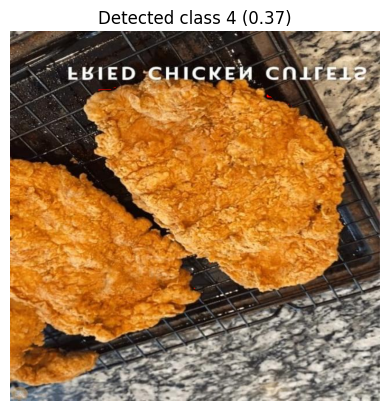

In [ ]:
# --- Parse detection output ---
# YOLO output shape: (num_classes+4+mask_coeffs, num_anchors)
detect_output = detect_output.T  # (8400, 54)

boxes = detect_output[:, :4]
mask_coeffs = detect_output[:, 4:36]  # 32 mask coefficients
confidence = detect_output[:, 36]      # already sigmoid-activated
class_probs = detect_output[:, 37:]    # already sigmoid-activated

# --- Select class and confidence ---
class_ids = np.argmax(class_probs, axis=1)
scores = confidence * class_probs[np.arange(len(class_probs)), class_ids]

# --- Filter detections ---
mask = scores > 0.25
boxes, mask_coeffs, scores, class_ids = boxes[mask], mask_coeffs[mask], scores[mask], class_ids[mask]

print(f"{len(scores)} detections above threshold")

# --- Pick best detection ---
if len(scores) > 0:
    best_idx = np.argmax(scores)
    best_box = boxes[best_idx]
    best_mask_coeff = mask_coeffs[best_idx]

    # --- Reconstruct mask ---
    mask = np.dot(proto_output.reshape(-1, 32), best_mask_coeff)
    mask = mask.reshape(160, 160)
    # ✅ no sigmoid needed here if proto_output already passes through it in TFLite
    mask = cv2.resize(mask, (640, 640))
    mask = (mask > 0.5).astype(np.uint8)

    # Visualize
    overlay = img.copy()
    overlay[mask == 1] = (255, 0, 0)  # blue overlay
    plt.imshow(overlay)
    plt.title(f"Detected class {int(class_ids[best_idx])} ({scores[best_idx]:.2f})")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ No detections above threshold.")

# Get Real Food Nutrition

#### Get Model & Load an Image

##### Unzip Food Segmentation Model (if need)

In [4]:
!unzip /content/yolo_food_segmenttaion_model.zip

Archive:  /content/yolo_food_segmenttaion_model.zip
   creating: yolo_food_segmenttaion_model/
  inflating: yolo_food_segmenttaion_model/best.pt  


##### Load Food Segmentation Model

In [6]:
food_model = YOLO("/content/yolo_food_segmenttaion_model/best.pt")

##### Load an Image

In [9]:
img_path = "/content/food-coin-4.jpg"

#### Predict Food Segmentation

##### Predict Food


image 1/1 /content/food-coin-4.jpg: 640x480 1 Nasi Putih, 1 Steak Sapi, 98.9ms
Speed: 18.8ms preprocess, 98.9ms inference, 339.9ms postprocess per image at shape (1, 3, 640, 480)


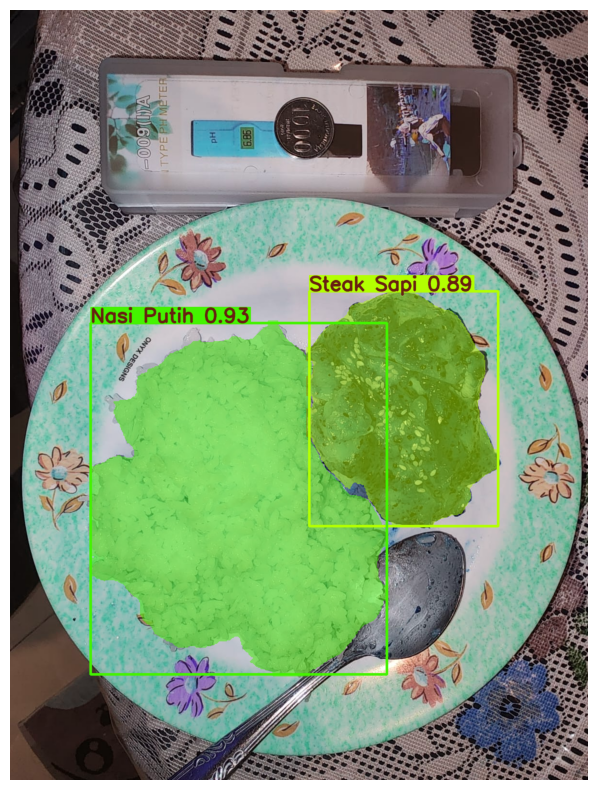

In [10]:
results = food_model(img_path)

food_img_result = results[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(food_img_result)
plt.axis("off")
plt.show()

##### Get Detected Food Class Name

In [11]:
class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
class_names = [results[0].names[class_id] for class_id in class_ids]

class_names

['Nasi Putih', 'Steak Sapi']

##### Get Detected Object Confidence

In [12]:
confidences = results[0].boxes.conf.cpu().numpy()
confidences = confidences.tolist()

confidences

[0.9349903464317322, 0.889576256275177]

##### Make Masks into Black & White

Black is background<br>
White is detected object

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
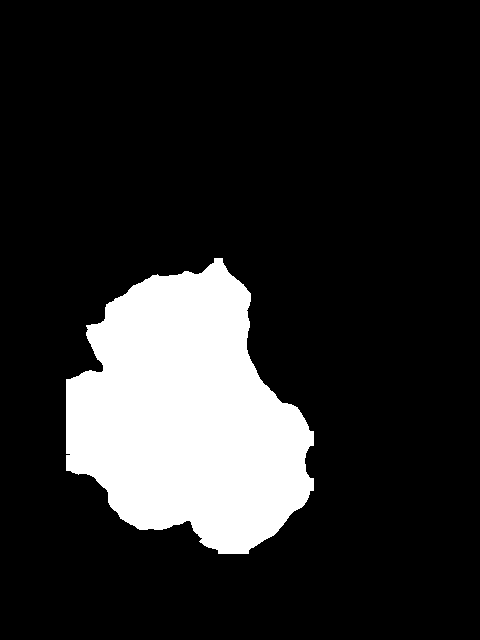

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
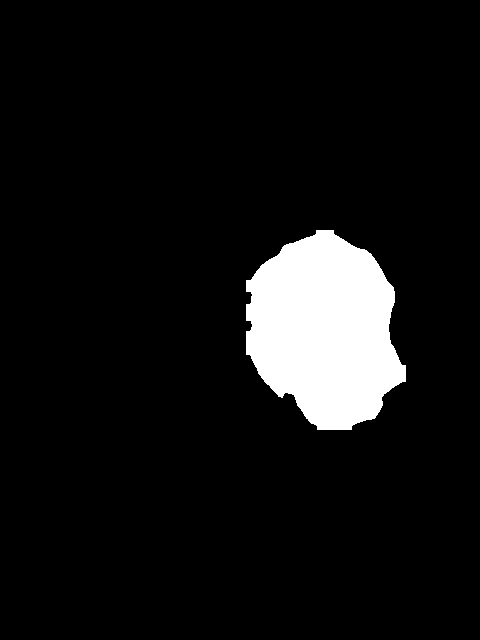

In [13]:
food_masks = results[0].masks.data.cpu().numpy()
food_masks = ((food_masks > 0.5).astype(np.uint8)) * 255

for mask in food_masks:
  display(mask)